In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlub-learning-to-count/train.txt
/kaggle/input/mlub-learning-to-count/test/test/test_composite000000426.png
/kaggle/input/mlub-learning-to-count/train/train/train_composite000012068.png


In [2]:
import numpy as np # linear algebra
import pandas as pd 

In [3]:
df_train = pd.read_csv('/kaggle/input/mlub-learning-to-count/train.txt',sep=' ',header=None)

# take only the first 200 images
#df_train = df_train.head(500)

# Estructura del dataset

In [4]:
df_train

,0,1
0,/train/train_composite000000000.png,20
1,/train/train_composite000000001.png,18
2,/train/train_composite000000002.png,7
3,/train/train_composite000000003.png,18
4,/train/train_composite000000004.png,17
...,...,...
14995,/train/train_composite000014995.png,22
14996,/train/train_composite000014996.png,7
14997,/train/train_composite000014997.png,2
14998,/train/train_composite000014998.png,29


In [5]:
df_train.describe()

,1
count,15000.000000
mean,14.377067
std,8.655134
min,0.000000
25%,7.000000
50%,14.000000
75%,22.000000
max,29.000000


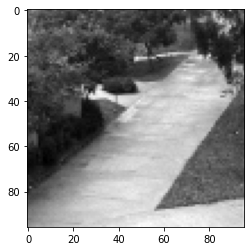

In [6]:
import imageio
from skimage import transform,io
import matplotlib.pyplot as plt
# read images and store into a np array

data_dir = '/kaggle/input/mlub-learning-to-count/train/'
im_size = 96
N = df_train.shape[0]
X = np.zeros((N, im_size,im_size))
y = np.zeros((N))
cont =0

for ind, item in df_train.iterrows():
    im = imageio.imread(data_dir + item[0])/255. 
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X[cont, :,:] = small_im
    y[cont] = item[1]
    cont+=1
    
plt.imshow(small_im,cmap='gray')
plt.show()

Tamaño de la imagen: (158, 158)
Etiqueta num de personas: 0


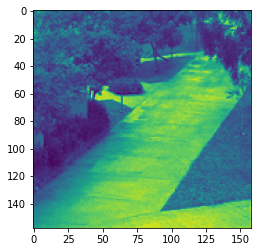

In [7]:
im = imageio.imread(data_dir + item[0])
num = item[1]
print("Tamaño de la imagen: " + str(im.shape))
print("Etiqueta num de personas: " + str(num))


plt.imshow(im)
plt.show()

# Aumentacion de las imágenes

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = "nearest")

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.33, random_state=66)

X_train = X_train.reshape(X_train.shape + (1,))
X_val = X_val.reshape(X_val.shape + (1,))

In [10]:
## With a Neural Network

import tensorflow as tf
from tensorflow import keras
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [11]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [12]:
def res_block(X, filter, stage):

  # Bloque Convolucional
  X_copy = X

  f1 , f2, f3 = filter

  # Camino Principal
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Camino Corto
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # Añadir
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Bloque de Identidad 1
  X_copy = X


  # Camino Principal
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # Añadir
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Bloque de Identidad 2
  X_copy = X


  # Camino Principal
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # Añadir
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [13]:
input_shape = (96, 96, 1)

# Tamaño del tensor de entrada
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - Fase
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - Fase
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - Fase
X = res_block(X, filter= [128,128,512], stage= 3)

# 4 - Fase
#X = res_block(X, filter= [256,256,1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Capa Final
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(1, activation = 'linear')(X)


model = Model( inputs= X_input, outputs = X)

In [14]:
model.layers

In [15]:
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________

In [16]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

In [17]:
model.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)

checkpointer = ModelCheckpoint(filepath = 'count_objets_model.hdf5', verbose = 1, save_best_only = True)

In [25]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), epochs= 300, callbacks=[earlystopping,checkpointer])

Epoch 1/300
158/158 [==============================] - ETA: 0s - loss: 10.7604 - accuracy: 0.0342
Epoch 00001: val_loss did not improve from 212.03174
158/158 [==============================] - 13s 83ms/step - loss: 10.7604 - accuracy: 0.0342 - val_loss: 268.0586 - val_accuracy: 0.0283
Epoch 2/300
158/158 [==============================] - ETA: 0s - loss: 8.9206 - accuracy: 0.0363
Epoch 00002: val_loss did not improve from 212.03174
158/158 [==============================] - 12s 76ms/step - loss: 8.9206 - accuracy: 0.0363 - val_loss: 261.2471 - val_accuracy: 0.0339
Epoch 3/300
158/158 [==============================] - ETA: 0s - loss: 8.1735 - accuracy: 0.0361
Epoch 00003: val_loss improved from 212.03174 to 119.91277, saving model to count_objets_model.hdf5
158/158 [==============================] - 13s 81ms/step - loss: 8.1735 - accuracy: 0.0361 - val_loss: 119.9128 - val_accuracy: 0.0339
Epoch 4/300
158/158 [==============================] - ETA: 0s - loss: 6.5461 - accuracy: 0.0388

Epoch 29/300
158/158 [==============================] - ETA: 0s - loss: 4.7500 - accuracy: 0.0425 ETA: 0s - loss: 4.7
Epoch 00029: val_loss did not improve from 5.49490
158/158 [==============================] - 13s 81ms/step - loss: 4.7500 - accuracy: 0.0425 - val_loss: 9.4273 - val_accuracy: 0.0317
Epoch 30/300
158/158 [==============================] - ETA: 0s - loss: 3.9939 - accuracy: 0.0456
Epoch 00030: val_loss did not improve from 5.49490
158/158 [==============================] - 12s 74ms/step - loss: 3.9939 - accuracy: 0.0456 - val_loss: 61.2540 - val_accuracy: 0.0317
Epoch 31/300
158/158 [==============================] - ETA: 0s - loss: 4.0199 - accuracy: 0.0450
Epoch 00031: val_loss did not improve from 5.49490
158/158 [==============================] - 12s 76ms/step - loss: 4.0199 - accuracy: 0.0450 - val_loss: 87.1155 - val_accuracy: 0.0317
Epoch 32/300
158/158 [==============================] - ETA: 0s - loss: 4.0069 - accuracy: 0.0482
Epoch 00032: val_loss did not impr

Epoch 58/300
158/158 [==============================] - ETA: 0s - loss: 3.5234 - accuracy: 0.0471
Epoch 00058: val_loss did not improve from 3.85550
158/158 [==============================] - 12s 74ms/step - loss: 3.5234 - accuracy: 0.0471 - val_loss: 15.7209 - val_accuracy: 0.0317
Epoch 59/300
158/158 [==============================] - ETA: 0s - loss: 3.4376 - accuracy: 0.0483
Epoch 00059: val_loss did not improve from 3.85550
158/158 [==============================] - 12s 74ms/step - loss: 3.4376 - accuracy: 0.0483 - val_loss: 43.3461 - val_accuracy: 0.0317
Epoch 60/300
158/158 [==============================] - ETA: 0s - loss: 3.2878 - accuracy: 0.0500
Epoch 00060: val_loss did not improve from 3.85550
158/158 [==============================] - 13s 80ms/step - loss: 3.2878 - accuracy: 0.0500 - val_loss: 45.5521 - val_accuracy: 0.0317
Epoch 61/300
158/158 [==============================] - ETA: 0s - loss: 3.4978 - accuracy: 0.0489
Epoch 00061: val_loss did not improve from 3.85550
15

Epoch 87/300
158/158 [==============================] - ETA: 0s - loss: 3.0475 - accuracy: 0.0494
Epoch 00087: val_loss did not improve from 3.85550
158/158 [==============================] - 12s 77ms/step - loss: 3.0475 - accuracy: 0.0494 - val_loss: 20.3152 - val_accuracy: 0.0317
Epoch 00087: early stopping


In [26]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

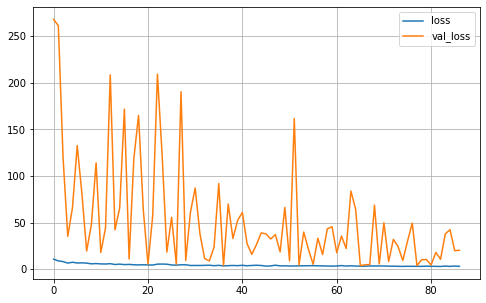

In [27]:
import pandas as pd

pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0.4, 0.8)
plt.show()

4.507242409542178

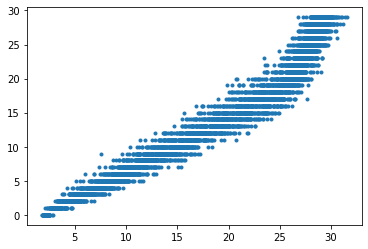

In [28]:
from sklearn.metrics import mean_squared_error
y_model1 = model.predict(X_val)

plt.plot(y_model1,y_val,'.')
np.sqrt(mean_squared_error(y_model1,y_val))

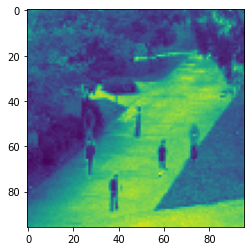

In [29]:
## evaluate test and generate submission
test_dir = '/kaggle/input/mlub-learning-to-count/test/test/'
im_size = 96
N = 500
X_test = np.zeros((N, im_size,im_size))
cont =0

for x in range(500):
    im       = imageio.imread(test_dir + 'test_composite'+str(x).zfill(9) + '.png')/255.
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X_test[cont, :,:] = small_im
    cont+=1
    
plt.imshow(small_im)
plt.show()

In [30]:
X_test = X_test.reshape(X_test.shape + (1,))

# create the file to make the sumbission

y_test = model.predict(X_test)
y_test = [int(x[0]) for x in y_test]

df_output = pd.DataFrame(y_test)
df_output.index.name = 'index'
df_output.columns = ['prediction']
df_output.to_csv('output.csv')
